 (Full) Gradient Descent (GD)
• Stochastic Gradient Descent (SGD)
• SGD with Momentum (SGDM)
• Adaptive Gradient (AdaGrad)
• RMSProp
• AdaDelta
• Adaptive Momentum (ADAM)

Describe each of the techniques in detail. Compare and contrast the relative advantages and
disadvantages of each of the techniques. Are there specific types of datasets where one technique is expected to perform better than the other? if so, why? Provide detailed justifications
for each.

Datasets: linearly separable and non-separable
https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
https://stackoverflow.com/questions/47961536/how-to-generate-linear-separable-dataset-by-using-sklearn-datasets-make-classifi

1) write logreg
2) write cost functions: 1) linear, 2) log
https://www.internalpointers.com/post/cost-function-logistic-regression
3) finish methods

In [2]:
import numpy as np
import pandas as pd
import time
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [3]:
def split(dataset, y, ratio):
    msk = np.random.rand(len(dataset)) < ratio
    return dataset[msk], dataset[~msk], y[msk], y[~msk]

In [4]:
def logreg(X, theta):
    return 1/(1+np.exp(-(X @ theta)))
              
def log_cost(pred, y):
    n = len(y)
    eps = 0.000001
    return np.sum(y*-1*np.log(pred+eps) - (1-y)*np.log(1-pred+eps))/n
                    
def lin_cost(pred, y):
    n = len(y)
    return np.sum(np.square(pred-y))/(2*n)

def predict(X, theta, y):
    label = np.round(logreg(X, theta))
    return np.sum(label == y)/len(y)

In [5]:
def gd(X, y, eta, n, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    cost_history = []
    for i in range(n):
        #adjust theta
        pred = logreg(X, theta)
        theta = theta - eta * 1/len(y) * (X.T @ (pred-y))
        cost_history.append(log_cost(pred, y))
    return theta, cost_history

def sgd(X, y, eta, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    cost_history = []
    
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #adjust theta
            pred = logreg(sample_X, theta)
            theta = theta - eta * 1/batch * (sample_X.T @ (pred-sample_y))
            j += batch
        pred = logreg(X, theta)
        cost_history.append(log_cost(pred, y))
    return theta, cost_history

def sgdm(X, y, eta, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    cost_history = []
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #get prediction
            pred = logreg(sample_X, theta)

            #if first time, initialize v_{t-1}
            if i == 0 and j == 0:
                theta = theta - eta * 1/batch * (sample_X.T @ (pred-sample_y))
                last_v = theta

            #else, adjust theta
            else:
                last_v = gamma * last_v + eta * 1/len(sample_y) * (sample_X.T @ (pred-sample_y))
                theta = theta - last_v
            j += batch
        
        pred = logreg(X, theta)
        cost_history.append(log_cost(pred, y))
        
    return theta, cost_history

def adagrad(X, y, eta, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    cost_history = []
    
    G = np.zeros((f, f))
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #get prediction
            pred = logreg(sample_X, theta)

            #compute G        
            
            gradient = sample_X.T @ (pred-sample_y)
            diag += gradient**2
            temp_diag = eta/(np.sqrt(diag)+eps)
            np.fill_diagonal(G, temp_diag)

            #compute theta
            theta = theta - G @ gradient
            j+= batch
         
        pred = logreg(X, theta)
        cost_history.append(log_cost(pred, y))
    return theta, cost_history

def rmsprop(X, y, eta, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    prev_g2 = 0 
    G = np.zeros((f, f))
    cost_history = []
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

        
            #get predictions and gradients
            pred = logreg(sample_X, theta)

            #compute G       
            G = np.zeros((f, f))
            gradient = sample_X.T @ (pred-sample_y)
            prev_g2 = gamma*prev_g2 + (1-gamma)*gradient**2
            temp_diag = eta/(np.sqrt(prev_g2)+eps)
            np.fill_diagonal(G, temp_diag)

            #compute theta
            theta = theta - G @ gradient
        
            j+=batch
        pred = logreg(X, theta)
        cost_history.append(log_cost(pred, y))
    return theta, cost_history

def adadelta(X, y, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    prev_e_delta = 0 
    prev_g2 = 0
    prev_delta = 0
    cost_history = []
    
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

        
            #get predictions and gradients
            pred = logreg(sample_X, theta)

            #compute rms_g
            gradient = sample_X.T @ (pred-sample_y)
            prev_g2 = gamma*prev_g2 + (1-gamma)*gradient**2 
            rms_g = np.sqrt(prev_g2+eps)


            #compute rms_delta
            e_delta = gamma*prev_e_delta+(1-gamma)*prev_delta**2
            prev_e_delta = e_delta
            rms_delta = np.sqrt(e_delta+eps)

            #get weights
            prev_delta = -1*rms_delta/rms_g * gradient
            theta = theta + prev_delta
        
            j += batch
        pred = logreg(X, theta)
        cost_history.append(log_cost(pred, y))
    return theta, cost_history

def adam(X, y, eta, n, batch, b_1, b_2, log=True):
    f = X.shape[1]
    theta = np.zeros(f)
    eps = 0.0000001
    m = 0
    v = 0
    cost_history =[]
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #get predictions and gradients
            pred = logreg(sample_X, theta)
            gradient = sample_X.T @ (pred-sample_y)

            m = b_1*m+(1-b_1)*gradient
            v = b_2*v+(1-b_2)*(gradient**2)


            m_hat = m/(1-b_1**(n+1))
            v_hat = v/(1-b_2**(n+1))
            theta = theta - eta / (np.sqrt(v_hat) + eps) * m_hat
            j += batch
        pred = logreg(X, theta)
        cost_history.append(log_cost(pred, y))
    return theta, cost_history

# Get data

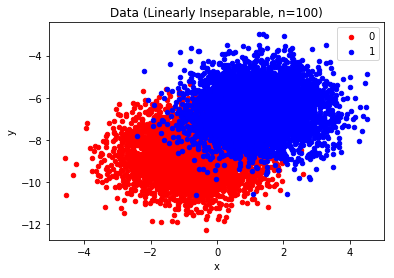

In [320]:
X, y = make_blobs(n_samples=10000, centers=2, n_features=2)
m=len(y)
X = np.hstack((np.ones((m,1)),X))
df = pd.DataFrame(dict(x=X[:,1], y=X[:,2], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

plt.title("Data (Linearly Inseparable, n=100)")
plt.show()

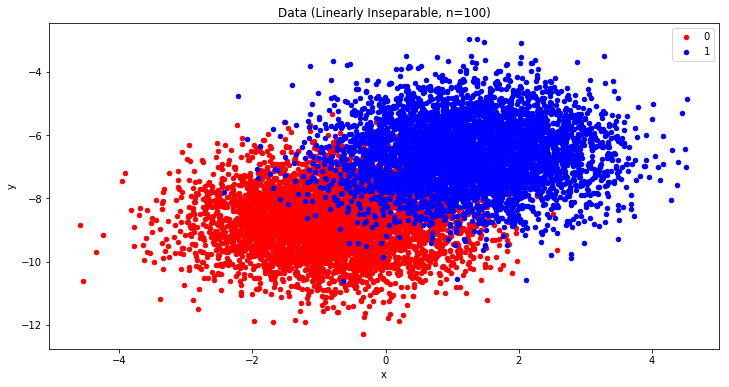

In [321]:
df = pd.DataFrame(dict(x=X[:,1], y=X[:,2], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots(figsize=(12, 6))
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

plt.title("Data (Linearly Inseparable, n=100)")
plt.show()

In [322]:
train_X, test_X, train_y, test_y = split(X, y, 0.7)

In [ ]:
eta = 0.005
n = 1000
gamma = 0.2
batch_s = 1
batch = 5
b_1 = 0.9
gamma_sgdm = 0.1
b_2 = 0.999
eta_rms = 0.001

gd_theta, gd_cost = gd(train_X, train_y, eta, n)
sgd_theta, sgd_cost = sgd(train_X, train_y, eta, n, batch_s)
sgdm_theta, sgdm_cost = sgdm(train_X, train_y, eta, gamma_sgdm, n, batch_s)
adagrad_theta, adagrad_cost = adagrad(train_X, train_y, eta, n, batch)
rmsprop_theta, rms_cost = rmsprop(train_X, train_y, eta_rms, gamma, n, batch)
adadelta_theta, adadelta_cost = adadelta(train_X, train_y, gamma, n, batch)
adam_theta, adam_cost = adam(train_X, train_y, eta, n, batch, b_1, b_2)

adam_theta

# Get decision boundaries

In [ ]:
df = pd.DataFrame(dict(x=train_X[:,1], y=train_X[:,2], label=train_y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots(figsize=(12, 6))
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

x_p = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
y_p = (-gd_theta[0] -gd_theta[1]* x_p)/gd_theta[2]
y_p2 = (-sgd_theta[0] -sgd_theta[1]* x_p)/sgd_theta[2]
y_p3 = (-sgdm_theta[0] -sgdm_theta[1]* x_p)/sgdm_theta[2]
y_p4 = (-adagrad_theta[0] -adagrad_theta[1]* x_p)/adagrad_theta[2]
y_p5 = (-rmsprop_theta[0] -rmsprop_theta[1]* x_p)/rmsprop_theta[2]
y_p6 = (-adadelta_theta[0] -adadelta_theta[1]* x_p)/adadelta_theta[2]
y_p7 = (-adam_theta[0] -adam_theta[1]* x_p)/adam_theta[2]
ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
plt.plot(x_p, y_p, label="GD")
plt.plot(x_p, y_p2, label="SGD")
plt.plot(x_p, y_p3, label="SGDM")
plt.plot(x_p, y_p4, label="Adagrad")
plt.plot(x_p, y_p5, label="RMSProp")
plt.plot(x_p, y_p6, label="Adadelta")
plt.plot(x_p, y_p7, label="Adam")
plt.title("Visualization of Decision Boundary (LS, n=10000)")
plt.legend()
plt.show()

# Get loss function convergence

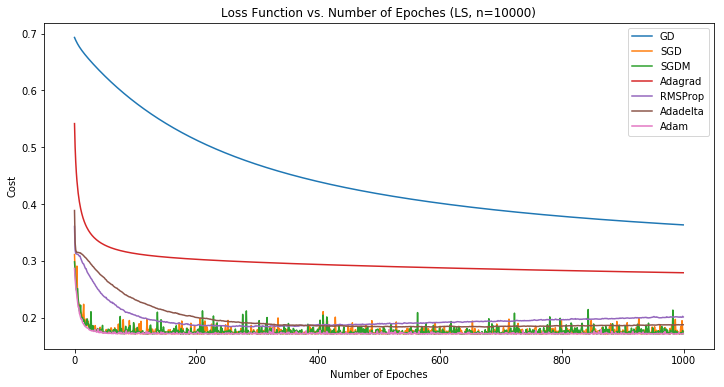

In [327]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(list(range(n)), gd_cost, label="GD")
plt.plot(list(range(n)), sgd_cost, label="SGD")
plt.plot(list(range(n)), sgdm_cost, label="SGDM")
plt.plot(list(range(n)), adagrad_cost, label="Adagrad")
plt.plot(list(range(n)), rms_cost, label="RMSProp")
plt.plot(list(range(n)), adadelta_cost, label="Adadelta")
plt.plot(list(range(n)), adam_cost, label="Adam")
plt.title("Loss Function vs. Number of Epoches (LS, n=10000)")
plt.xlabel("Number of Epoches")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Time taken

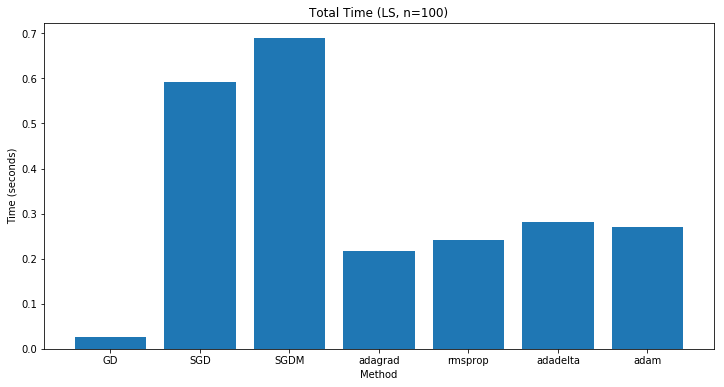

In [302]:
fig, ax = plt.subplots(figsize=(12, 6))
names = ["GD", "SGD", "SGDM", "adagrad", "rmsprop", "adadelta", "adam"]

plt.title("Total Time (LS, n=10000)")
plt.xlabel("Method")
plt.ylabel("Time (seconds)")
plt.bar(names, times)
plt.show()

# Accuracy performance

In [303]:
train_perf_acc = []
test_perf_acc = []
total = [i+1 for i in range(10)]
batch_s = 1
batch = 3
for n in total:
    if (n-1) % 50:
        print("On #" + str(n))
        
    gd_theta, c = gd(train_X, train_y, eta, n)
    print(gd_theta)
    sgd_theta, c = sgd(train_X, train_y, eta, n, batch_s)
    sgdm_theta, c = sgdm(train_X, train_y, eta, gamma_sgdm, n, batch_s)
    adagrad_theta, c = adagrad(train_X, train_y, eta, n, batch)
    rmsprop_theta, c = rmsprop(train_X, train_y, eta_rms, gamma, n, batch)
    adadelta_theta, c = adadelta(train_X, train_y, gamma, n, batch)
    adam_theta, c = adam(train_X, train_y, eta, n, batch, b_1, b_2)

    train_perf_acc.append([predict(train_X, gd_theta, train_y), predict(train_X, sgd_theta, train_y), \
                       predict(train_X, sgdm_theta, train_y), predict(train_X, adagrad_theta, train_y), \
                       predict(train_X, rmsprop_theta, train_y), predict(train_X, adadelta_theta, train_y), \
                       predict(train_X, adam_theta, train_y)])
                      
    test_perf_acc.append([predict(test_X, gd_theta, test_y), predict(test_X, sgd_theta, test_y), \
                       predict(test_X, sgdm_theta, test_y), predict(test_X, adagrad_theta, test_y), \
                       predict(test_X, rmsprop_theta, test_y), predict(test_X, adadelta_theta, test_y), \
                       predict(test_X, adam_theta, test_y)])


[ 2.80420275e-05  1.49283890e-02 -5.09195815e-03]
On #2
[ 0.00014471  0.02882857 -0.00943415]
On #3
[ 0.00033974  0.04179844 -0.01310653]
On #4
[ 0.0006031   0.05393375 -0.01618716]
On #5
[ 0.00092548  0.06532378 -0.01874864]
On #6
[ 0.00129849  0.07604933 -0.02085645]
On #7
[ 0.00171471  0.08618207 -0.02256846]
On #8
[ 0.00216771  0.09578493 -0.02393525]
On #9
[ 0.0026519   0.10491276 -0.02500068]
On #10
[ 0.00316248  0.11361324 -0.02580265]


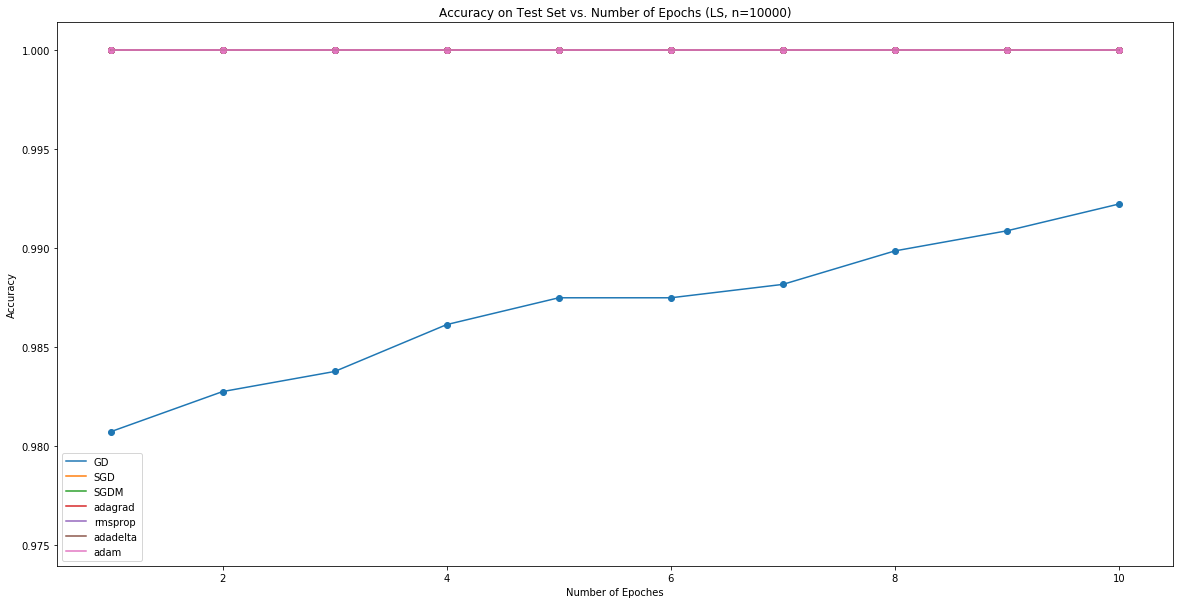

In [308]:
x_acc = total
xnew = np.linspace(min(x_acc), max(x_acc), 50) 

fig, ax = plt.subplots(figsize=(20, 10))
train_acc_arr = np.array(train_perf_acc)
test_acc_arr = np.array(test_perf_acc)

l = train_acc_arr.shape[1]
lines_train_acc = [test_acc_arr[:, i] for i in range(l)]
lines_test_acc = [test_acc_arr[:, i] for i in range(l)]

splines = [np.poly1d(np.polyfit(x_acc, acc, 3)) for acc in lines_test_acc]
y_spl = [splines[i](xnew) for i in range(l)]


# for i,l in zip(y_spl,names):  
#     plt.plot(xnew,i,label='l')
#     plt.legend(names)    
    
for i,l in zip(lines_test_acc,names):  
    plt.scatter(x_acc,i,label='l')
    plt.plot(x_acc,i,label='l')
    plt.legend(names)    
    
plt.title("Accuracy on Test Set vs. Number of Epochs (LS, n=10000)")
plt.xlabel("Number of Epoches")
plt.ylabel("Accuracy")
plt.show()

# Times until convergence

In [306]:
count_list = []
count = 0
c=[]

for i in range(7):
    count=0
    c = []
    print(i)
    while count <2  or ((abs(c[-1]- c[-2]) > c[-2]*0.0002) and (abs(c[-1]- c[-2]) > 0.0001)):
        if i == 0: gd_theta, c = gd(train_X, train_y, eta, count+1)
        elif i == 1: sgd_theta, c = sgd(train_X, train_y, eta, count+1, batch_s)
        elif i == 2: sgdm_theta, c = sgdm(train_X, train_y, eta, gamma_sgdm, count+1, batch_s)
        elif i == 3: adagrad_theta, c = adagrad(train_X, train_y, eta, count+1, batch)
        elif i == 4: rmsprop_theta, c = rmsprop(train_X, train_y, eta_rms, gamma, count+1, batch)
        elif i == 5: adadelta_theta, c = adadelta(train_X, train_y, gamma, count+1, batch)
        else: adam_theta, c = adam(train_X, train_y, eta, count+1, batch, b_1, b_2)
        count += 1
    count_list.append(count)

0
1
2
3
4
5
6


In [269]:
count_list

[2, 2, 2, 2, 2, 2, 3]

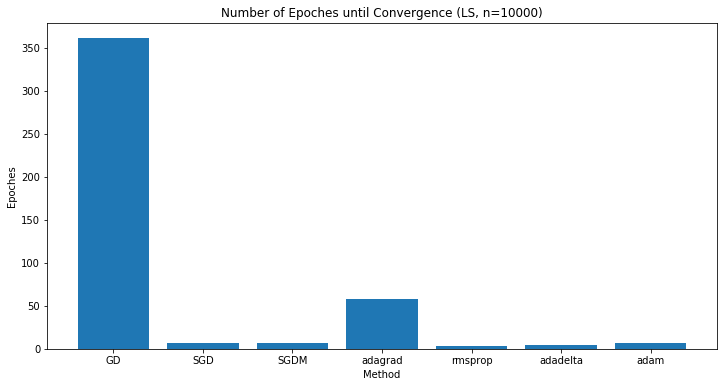

In [310]:
fig, ax = plt.subplots(figsize=(12, 6))
names = ["GD", "SGD", "SGDM", "adagrad", "rmsprop", "adadelta", "adam"]

plt.title("Number of Epoches until Convergence (LS, n=10000)")
plt.xlabel("Method")
plt.ylabel("Epoches")
ax.bar(names, count_list)
# ax2.bar(names, counts, color=color)
plt.show()

In [ ]:
x_acc = total
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(7):
    acc = test_acc_arr[:, i]
    xnew = np.linspace(min(x_acc), max(x_acc), 50) 
    z = np.polyfit(x_acc, acc, 5)  # type: BSpline

    power_smooth = z(xnew)
    plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
len(y_spl[0])